# 03 - Modeling

In [34]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import sklearn
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score
)
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import logging
import pickle
logging.getLogger().setLevel(logging.CRITICAL)


In [35]:
# Packages version
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'xgboost: {xgboost.__version__}')
print(f'sklearn: {sklearn.__version__}')
print(f'shap: {shap.__version__}')
print(f'imblearn: {imblearn.__version__}')
print(f'logging: {logging.__version__}')

pandas: 2.3.1
numpy: 2.2.6
matplotlib: 3.10.3
seaborn: 0.13.2
xgboost: 3.0.2
sklearn: 1.6.1
shap: 0.48.0
imblearn: 0.13.0
logging: 0.5.1.2


In [36]:
# Reading the Resulting Data Sets
df_train = pd.read_csv('./Data/Train_Data_Set.csv')
df_test = pd.read_csv('./Data/Test_Data_Set.csv')
df_val = pd.read_csv('./Data/Val_Data_Set.csv')

## - **🤖 Modeling**  

In [37]:
X_train = df_train.drop(columns = ['BAD','RES','AES','NKID'])
X_test = df_test.drop(columns = ['BAD','RES','AES','NKID'])
X_val = df_val.drop(columns = ['BAD','RES','AES','NKID'])

y_train = df_train['BAD']
y_test = df_test['BAD']
y_val = df_val['BAD']

rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [38]:
def model_selection(X_train, y_train, X_test, y_test, model_dict):
    metrics = []
    trained_models = {}

    for mod in model_dict:
        print(140 * '-')
        print(f"Training {mod}...")
        print(140 * '-')
        model = model_dict[mod]
        model.fit(X_train, y_train)

        # Salva modelo treinado
        trained_models[mod] = model

        # Obter scores para ROC
        if hasattr(model, "predict_proba"):
            y_pred_prob = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_pred_prob = model.decision_function(X_test)
        else:
            y_pred_prob = model.predict(X_test)

        # ROC Curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = roc_auc_score(y_test, y_pred_prob)

        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve ({mod})')
        plt.legend()
        plt.show()

        # Threshold 0.5
        y_pred_class = (y_pred_prob >= 0.5).astype(int)

        # Metrics
        acc = accuracy_score(y_test, y_pred_class)
        prec = precision_score(y_test, y_pred_class)
        rec = recall_score(y_test, y_pred_class)
        f1 = f1_score(y_test, y_pred_class)
        bacc = balanced_accuracy_score(y_test, y_pred_class)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred_class)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(4, 4))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix (Normalized by True Label) - {mod}')
        plt.show()

        # Store metrics
        metrics.append({
            'Model': mod,
            'ROC AUC': roc_auc,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'Balanced Accuracy': bacc
        })

    results_df = pd.DataFrame(metrics)
    return round(results_df, 3), trained_models


--------------------------------------------------------------------------------------------------------------------------------------------
Training XGBClassifier...
--------------------------------------------------------------------------------------------------------------------------------------------


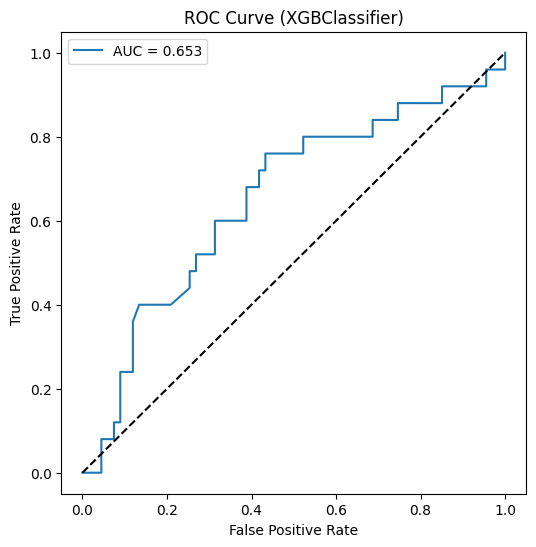

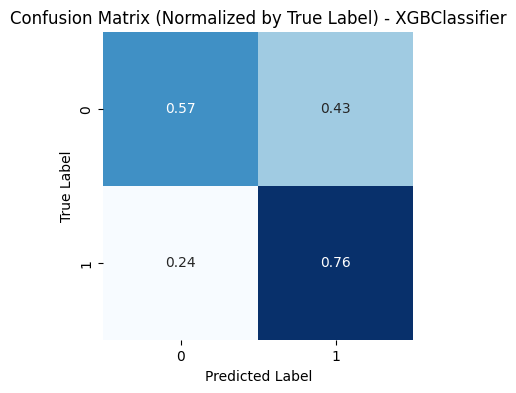

--------------------------------------------------------------------------------------------------------------------------------------------
Training LogisticRegression...
--------------------------------------------------------------------------------------------------------------------------------------------


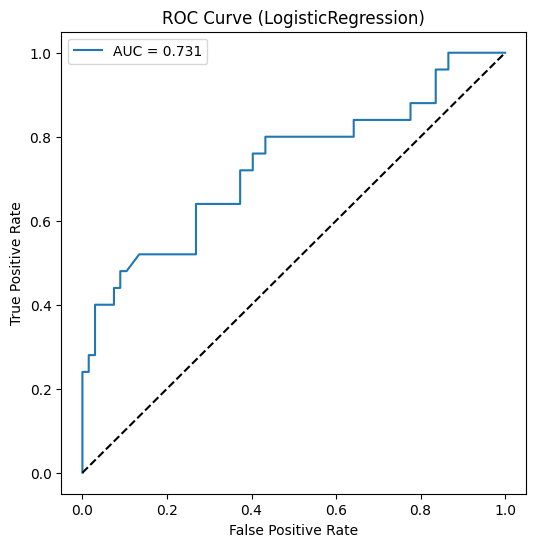

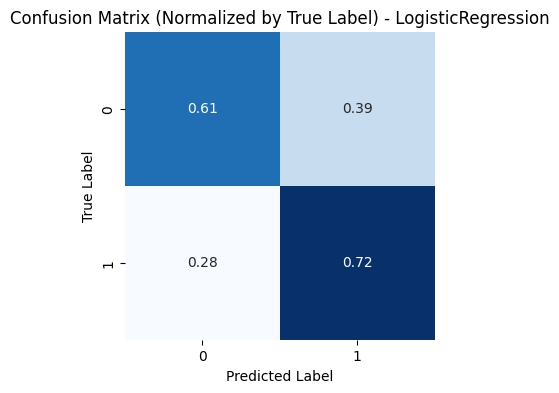

--------------------------------------------------------------------------------------------------------------------------------------------
Training RidgeClassifier...
--------------------------------------------------------------------------------------------------------------------------------------------


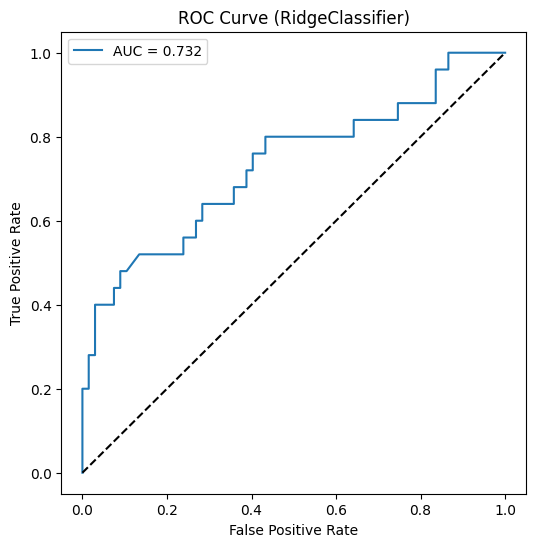

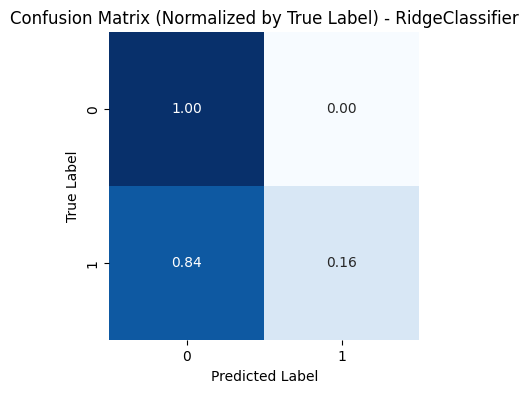

--------------------------------------------------------------------------------------------------------------------------------------------
Training LGBMClassifier...
--------------------------------------------------------------------------------------------------------------------------------------------


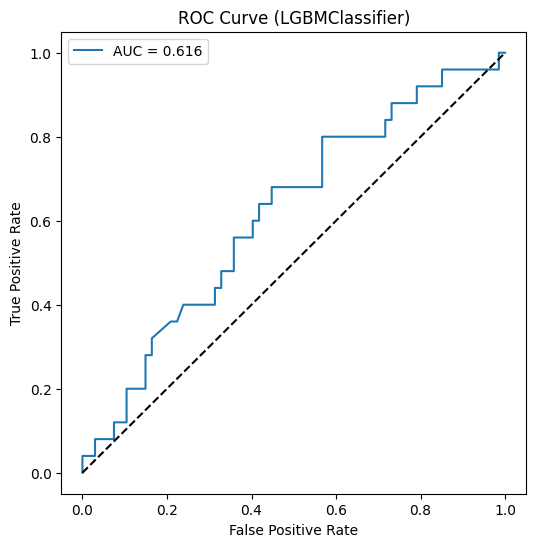

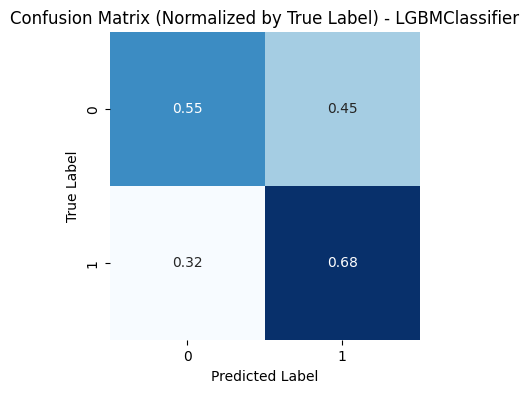

--------------------------------------------------------------------------------------------------------------------------------------------
Training KNeighborsClassifier...
--------------------------------------------------------------------------------------------------------------------------------------------


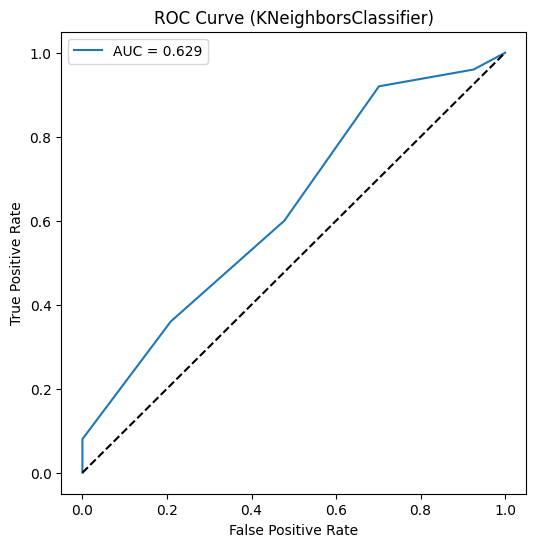

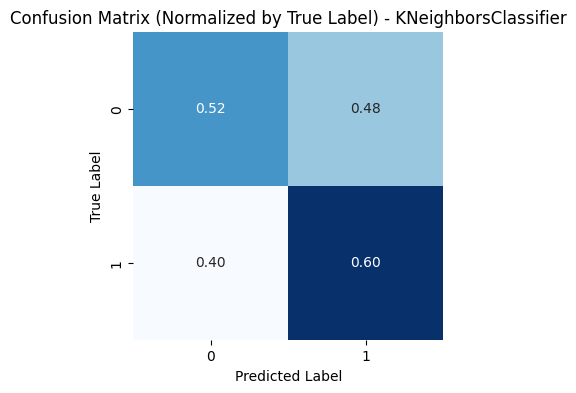

,Model,ROC AUC,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,XGBClassifier,0.653,0.620,0.396,0.76,0.521,0.664
1,LogisticRegression,0.731,0.641,0.409,0.72,0.522,0.666
2,RidgeClassifier,0.732,0.772,1.000,0.16,0.276,0.580
3,LGBMClassifier,0.616,0.587,0.362,0.68,0.472,0.616
4,KNeighborsClassifier,0.629,0.543,0.319,0.60,0.417,0.561


In [39]:
# Model Selection

model_dict = {'XGBClassifier':XGBClassifier(),
              'LogisticRegression':LogisticRegression(max_iter=1000), 
              'RidgeClassifier':RidgeClassifier(), 
              'LGBMClassifier':LGBMClassifier(verbose=-1),
              'KNeighborsClassifier':KNeighborsClassifier()
              }

metrics, trained_models = model_selection(X_train_under,y_train_under,X_test,y_test,model_dict)
metrics

Among the tested models, LogisticRegression() achieves the best discrimination between clients and has a low false positive rate, which is especially desirable in this context.

In [40]:

model = trained_models['LogisticRegression']
explainer = shap.LinearExplainer(model, X_train_under)

# Calculate SHAP values
shap_values = explainer(X_test)

shap_values_array = shap_values.values
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_ABS_SHAP': mean_abs_shap
}).sort_values(by='Mean_ABS_SHAP', ascending=False)

print(feature_importance_df)

       Feature  Mean_ABS_SHAP
2        DAINC       0.464748
4  RES(binary)       0.244687
0          YOB       0.210898
3         SINC       0.122581
5  AES(binary)       0.085001
1        DOUTL       0.026927
6         KIDS       0.021736


In [41]:
# Saving model
import pickle
with open('modelo_logistic.pkl', 'wb') as file:
    pickle.dump(model, file)